# K-Means Clustering on Wine Data
<a class = 'anchor' id = 'TOC'></a>

## Table of Contents

* [Project Outline](#outline)


* [Section 1: Initialization and EDA](#section1)



* [Section 2: Parameter Selection - Choosing k](#section2)
    
    * [Inertia and Silhouette Scores](#inertia)
    
    * [Silhouette Diagrams](#diagrams)


* [Section 3: Final Model and Results](#section3)


* [Section 4: Dimensionality Considerations](#section4)


* [Section 5: Summary](#section5)

<a class = 'anchor' id = 'outline'></a>

## Project Outline
* [Back To Top](#TOC)

$\textbf{Problem:}$

The majority of real world data can be classified into what is called unlabeled data, or data that does not have any pre-defined classifications or categories. This kind of data presents a challenge to model builders as they have to implement techniques that stray from the familiar train-test-validation process. Luckily, machine learning has a whole method class of unsupervised models called clustering models. The objective of these models is categorize unlabeled data into groups, or "clusters", by extrapolating information inherent in the data. 

Clustering algorithms have various applications, including customer segmentation, search engines, image segmentation, and can even be used as the input for a recommendation system, like Netflix or Amazon. This project deals with unlabeled wine data and attempts to cluster them into general categories of wine.

$\textbf{Project Objective:}$

The primary goal of this project is to build a clustering model by implementing k-means clustering on unlabeled wine data and determine how many categories of wine there are based on their chemical and spectral composition. 

$\textbf{Data:}$

The dataset consists of 178 observations, where each observation represents a particular wine. This dataset is unlabeled, so the name and type of wine has been omitted. Each wine has 13 continuous features describing its chemical composition. These include measures such as malic acid, total phenols, and magnesium. There are also spectral measures such as color intensity, hue, and OD280 (optical density at 280 nm). Note that these 13 features do not represent tasting notes, such as fruitiness or tannin; they are purely chemical measures.

$\textbf{EDA:}$

Exploratory data analysis was conducted to determine correlations and distributions among the features. It was determined that the majority of the features are uncorrelated with each other, and that most of them have nonelliptical scatterplots relative to each other. This means k-means is an applicable model to use. 

If the scatterplot relationships among the features were elliptical, then density-based clustering models, such as DBSCAN and Gaussian mixure models, would have been considered.

It was also determined that principal component analysis (PCA), to preserve 95% of the inherent variance (information), only reduced the dataset to 10 features. Thus is was decided to keep the original dataset and not implement any dimesionality reduction. The data was, however, passed through a StandardScaler for improved numerical performance. 

$\textbf{Model and Metrics:}$

K-means clustering is a clustering model that aims to separate n-dimensional data into k clusters or groups, where n is the number of features (13 in this case). It involves choosing k initial centroids, which are to represent the approximate centers of the clusters in the data, and then assigning each instance to a centroid according to a given distance metric. The centroids are then recalculated to be the averages of their assigned instances. With the new centroids, the instances are reassigned and the process iterates until convergence of centroid positions. In most cases, cnovergence is guaranteed.

The difficulty lies in choosing the one hyperparameter: k, the number of clusters. Parameter selection techniques were conducted to determine the optimal choice of k. These included calculating inertia, silhouette scores, and plotting silhouette diagrams for each k in a range of k values. 

It was determined that k = 3 is the most optimal choice, as it minimized overall interia and minimized the number of incorrect cluster assignments.

$\textbf{Results:}$

A final k-means clustering model with k = 3 was fit on the data and final metrics were given. To visualize the output of the clustering model, parallel coordinates plots were created for each cluster in the data. These are shown below and display how the wines in the different clusters vary from feature to feature.

$\textbf{Dimesionality Considerations:}$

A post-hoc analysis was conducted to observe how robust the k-means model was on dimensionally reduced data. To implement this, the final model was first fit on the full dataset, then the data was dimensionally reduced using three different reduction techniques, and then finally cluster predictions were obtained over each of the reduced datasets.

The dataset was reduced to two dimensions (two features) for each technique and the results were visualized in a scatterplot of the two features. Surprisingly, even though most of the inherent information was lost from reducing the data, the plots show that there are clearly three main clusters among the features. This supports the selection of k = 3.

$\textbf{Summary:}$

Overall, a k-means clustering model was fit to this dataset, with hyperparameter k empirically determined to be 3. This means that there are approximately 3 clusters found within the given feature set of wine varietals. Post-hoc analysis supported this result by visualizing model predictions over dimensionally reduced data.

<a class = 'anchor' id = 'section1'></a>

## Section 1: Initialization and EDA
* [Back To Top](#TOC)

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sc
import seaborn as sns
import sklearn as skl
%matplotlib inline

# Functions
from matplotlib.pyplot import rcParams
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.pipeline import Pipeline

# Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import wine dataset
wine_df = pd.read_csv('wine-clustering.csv' )
display(wine_df)

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


These are the 13 features in the dataset that represent the chemical composition of wine.

In [3]:
# List feature names and their data types
wine_df.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object

In [4]:
# Convert 'Magnesium' and 'Proline' to floats
# For future computational consistency
wine_df['Magnesium'] = wine_df['Magnesium'].astype('float64')
wine_df['Proline'] = wine_df['Proline'].astype('float64')
wine_df.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium               float64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                 float64
dtype: object

There are no missing values in this dataset, it has already been cleaned.

In [5]:
# Check for missing data
np.where(pd.isnull(wine_df))

(array([], dtype=int64), array([], dtype=int64))

Below shows summary statistics of the given features $\textbf{before}$ standard scaling.

In [6]:
# Summary stats of features
wine_df.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Below shows summary statistics of the given features $\textbf{after}$ standard scaling.

In [7]:
# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

# Summary stats of features
scaled_wine.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.619821e-16,-8.357859e-17,-8.657245e-16,-1.160121e-16,-1.995907e-17,-2.972030e-16,-4.016762e-16,4.079134e-16,-1.699639e-16,-1.122697e-17,3.717376e-16,2.919013e-16,-7.484650e-18
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246e+00,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-8.854682e-01,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,9.595986e-02,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,8.089974e-01,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515e+00,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


Below shows a heatmap of a correlation plot among the scaled features, with a correlation coefficient given for each pair of features.

We can see that most pairs of features do not have any strong relationships. There are a few high correlation coefficients, especially among those paired with total phenols and flavanoids. 

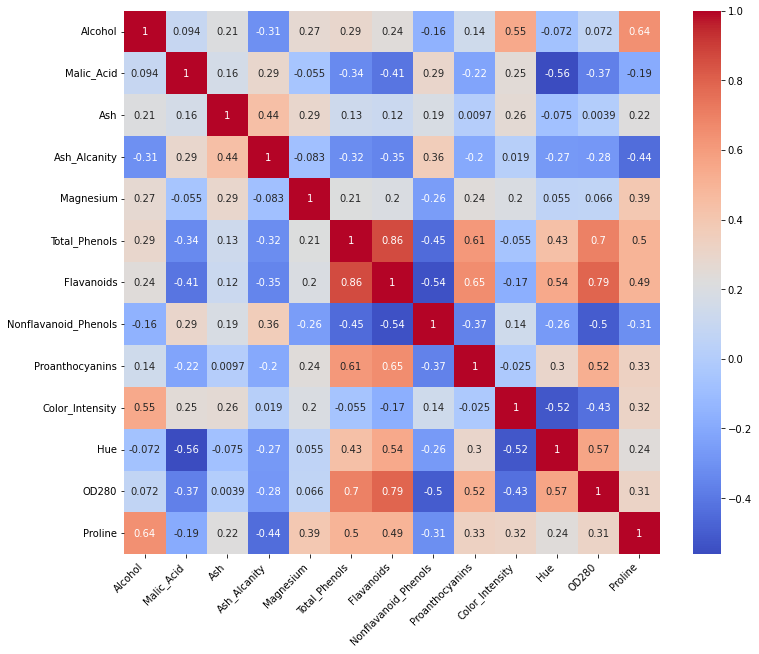

In [8]:
# Corrleation plot
corr = scaled_wine.corr()

rcParams['figure.figsize'] = 12, 10
fig, axs = plt.subplots()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax=axs);
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=45, ha='right')
plt.show();

Similar to the correlation heatmap above, the scatter matrix below displays the actual pairwise scatterplot for the features, with a KDE plot along the diagonal of that feature's distribution.

We can see that most plots don't have any strong relationship, except for those among alcohol, total phenols, and flavanoids. The scatterplots that contain these features display some slight relationships. The total phenol-flavanoid relationship is the strongest.

We can also use this plot to observe the shape of the distributions among the features. Most features appear to not have any strong elliptical distribution. The exceptions are malic acid, total phenols, flavanoids, and proline, which appear to have elliptical distributions.

Since the distributions generally don't have strong elliptical relationships, the k-means clustering model seems to be an appropriate fit for this dataset. For the few elliptically distributed features, the k-means model may underperform relative to a distribution-based clustering model such as DBSCAN or Gaussian mixture models.

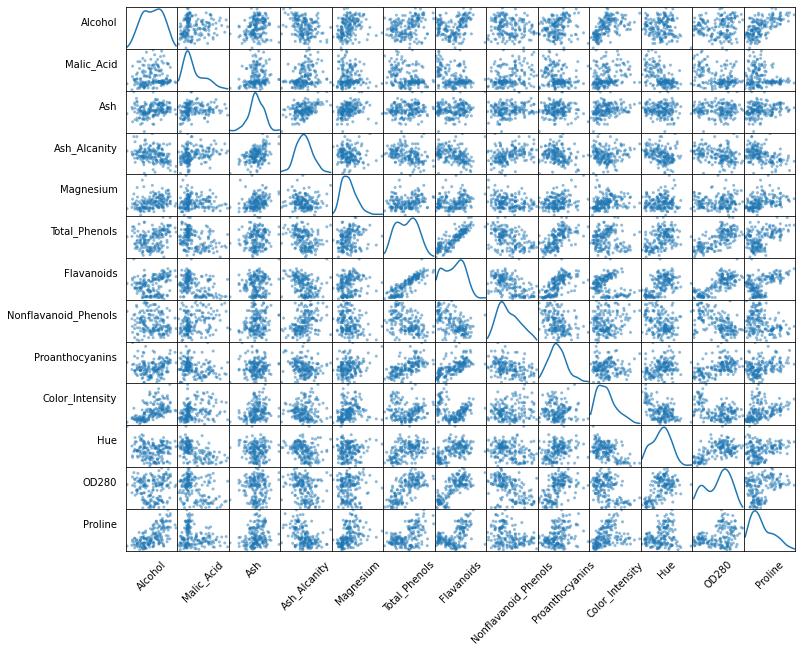

In [9]:
# Building scatter matrix plot
rcParams['figure.figsize'] = 12, 10
fig, axs = plt.subplots()
scatter_matrix = pd.plotting.scatter_matrix(scaled_wine, ax=axs, diagonal='kde');

for ax in scatter_matrix.ravel():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_horizontalalignment('right')
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 5
    
plt.show();

Below displays the effects of dimensionally reducing the dataset using principal component analysis (PCA).

Reducing the dimensions of the dataset can improve computational efficiency when a dataset is large in its feature space. This dataset is not very large, but it is good practice to check the effects of PCA. 

In order to maintain 95% of the data's inherent information (variance), PCA determined that the original 13 features could be reduced to 10, which is not much of an improvement. Thus, dimensionality reduction will not be implemented in this project before model fitting. That is, the model will be fit onto the full dataset.

In [10]:
# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

print('Shape of original data:', scaled_wine.shape)

new_wine = PCA(n_components=0.95).fit_transform(scaled_wine)
print('Shape of data after PCA:', new_wine.shape)

Shape of original data: (178, 13)
Shape of data after PCA: (178, 10)


<a class = 'anchor' id = 'section2'></a>

## Section 2: Parameter Selection - Choosing k
* [Back To Top](#TOC)

This section conducts parameter selection techniques to determine the optimal choice for k. Intuitively, we are asking how many clusters of wine are there in this dataset? Two? Five?

<a class = 'anchor' id = 'inertia'></a>

### Inertia and Silhouette Scores

$\textbf{Inertia}$ is a performance metric defined as the sum of squared distances between the instances and their closest centroid. Thus, the lower the inertia the better, as this means each instance is well within a cluster. 

However, one can easily see that inertia and k are negatively correlated. As k, the number of clusters, increases, the lower inertia will be. The more centroids there are, the closer a centroid is likely to be to an instance, lowering the distance. 

An basic parameter selection technique is the elbow plot, which plots inertia against k. We're looking for a distinct bend or kink in the plot, the "elbow", that indicates an optimal selection of k. We can see below that there is indeed a bend at k = 3, suggesting that there are 3 clusters in this dataset. The rapid change in slope around k = 3 implies that the inertia stops dramatically decreasing after 3 clusters. Selecting a k above 3 would risk overfitting.

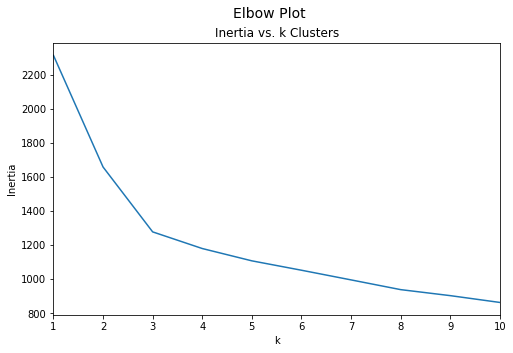

In [11]:
# KMeans Model
# Choosing k: Elbow plot

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

# Initialize values
k_vals = np.arange(1, 11)
int_vals = []
sil_vals = []

# Run KMeans for each k and record metrics
for k in k_vals:
    kmeans = KMeans(k, random_state=3)
    y_pred = kmeans.fit_predict(scaled_wine)
    int_vals.append(kmeans.inertia_)
    if k>1: sil_vals.append(silhouette_score(scaled_wine, kmeans.labels_))

# Plot elbow plot of inertia vs. k
rcParams['figure.figsize'] = 8,5
plt.plot(k_vals, int_vals);
plt.title('Inertia vs. k Clusters')
plt.suptitle('Elbow Plot', fontsize=14)
plt.xlim(1, 10)
plt.xlabel('k')
plt.ylabel('Inertia');

A more precise performance metric is the silhouette score.

A $\textbf{silhouette coefficient}$, $s_i$, is computed for each instance and is defined to be:
$$
s_i = \frac{(b - a)}{max(a, b)}, \hspace{0.5cm} i = 1,2,...,n
$$
where $a$ is the mean distance to the other instances in the same cluster (i.e., mean intra-cluster distance), $b$ is the mean nearest-cluster distance, and $n$ is the number of instances.

The $\textbf{silhouette score}$ is the mean sihouette coefficient over all the instances:
$$
S = \frac{1}{n}\sum_{i=1}^{n}s_i
$$

The silhouette score varies from -1 to +1, where a value close to +1 means an instance is inside its own cluster and far from other clusters (i.e., well-clustered), a value close to 0 means that an instance is near cluster boundaries (i.e., ambiguous cluster assignment), and a value close to -1 means an instance is far from its own cluster and close to other clusters (i.e., assigned to the wrong cluster).

Below displays the silhouette scores for a range of k values. We see that the two largest silhouette scores occur for k = 3 and k = 2. This implies that there are about 2 or 3 clusters within the data.

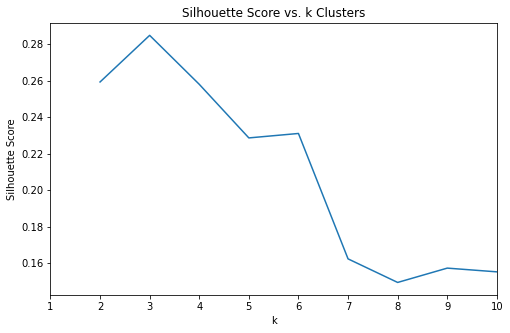

In [12]:
# KMeans Model
# Choosing k: Silhouette scores

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

# Initialize values
k_vals = np.arange(1, 11)
sil_vals = []

# Run KMeans for each k and record metrics
for k in k_vals:
    kmeans = KMeans(k, random_state=3)
    y_pred = kmeans.fit_predict(scaled_wine)
    if k>1: sil_vals.append(silhouette_score(scaled_wine, kmeans.labels_))

# Plot silhouette scores vs. k
rcParams['figure.figsize'] = 8,5
plt.plot(k_vals[1:], sil_vals)
plt.title('Silhouette Score vs. k Clusters')
plt.xlim(1, 10)
plt.xlabel('k')
plt.ylabel('Silhouette Score');

<a class = 'anchor' id = 'diagrams'></a>

### Silhouette Diagrams
* [Back To Top](#TOC)

The next performance metric is the $\textbf{silhouette diagram}$, which shows a more detailed look into the silhouette coefficients among the instances.

A silhouette diagram plots each instance's silhouette coefficient in a sideways bar graph. The coefficients are grouped by cluster and then sorted by value, creating knife-shaped blobs. Each knife-shape has a thickness and length, where the thickness represents the number of instances assigned to that cluster, and the length represents the largest silhouette coefficients in that cluster.

Additionally, a vertical line is plotted onto the graph that marks the silhouette score over all the instance, the same ones plotted above. 

In general, if a knife shape's length falls short of the vertical line, then this means that most of the instances in that cluster are closer to other instances than their own. So we want a silhouette diagram where all knife shapes extend beyond the vertical line. 

Also, when the knife shapes vary dramatically in their width, then this may imply disproportionate clustering; that is, too many instances may have been assigned to the wrong cluster, resulting in very large clusters and very small clusters. We want a silhouette diagram with clusters of relatively similar size.

Below displays a silhouette diagram for each k in a range of values. We see that the first two diagrams for k = 2 and k = 3 satisfy our requirements for silhouette diagrams. The diagrams for k greater than 3 display some serious issues: knife shapes that fall short of the vertical line, knife shapes of varying width, and even some knife shapes that have a large number of negative value.

It seems that k = 2 or k = 3 are the best choices for this dataset. 

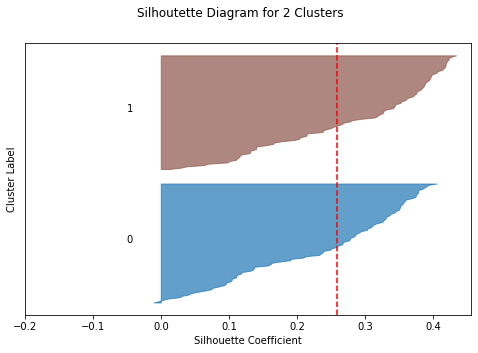

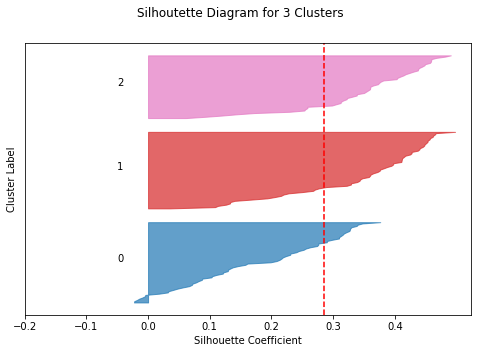

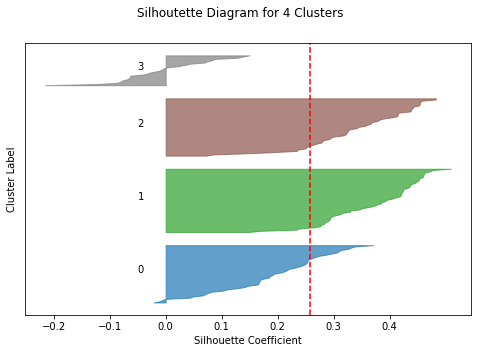

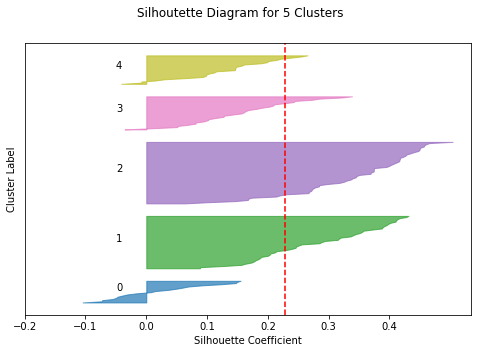

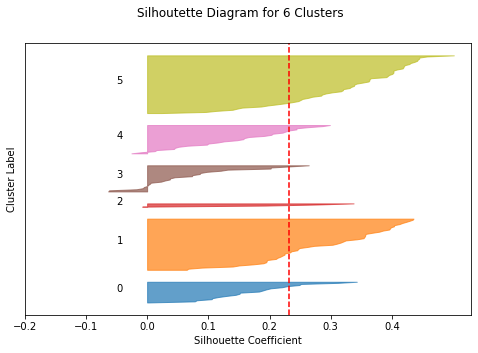

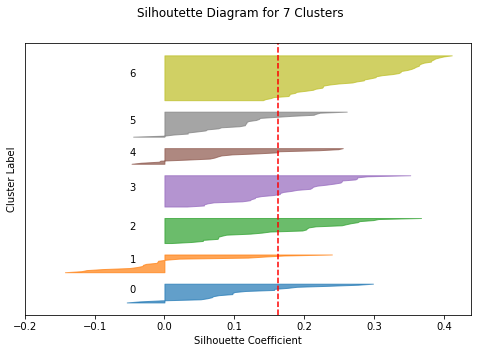

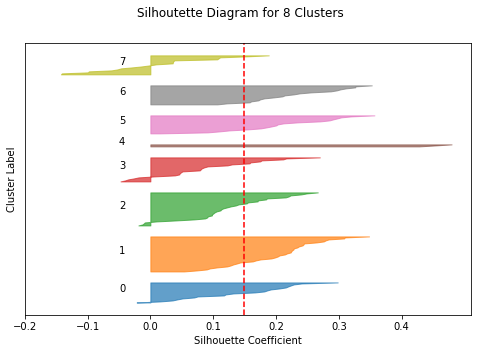

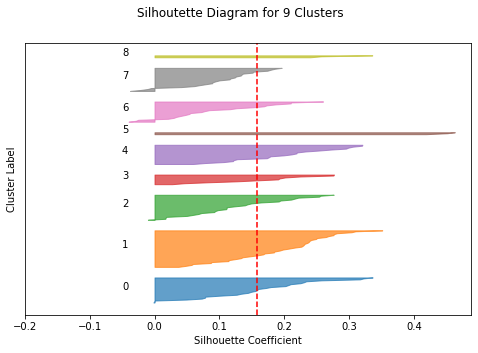

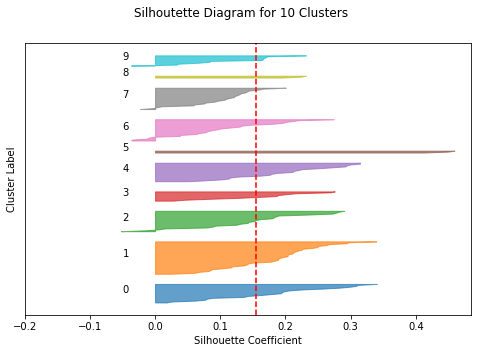

In [13]:
# KMeans Model
# Choosing k: Silhouette Diagrams

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

# Initialize values
k_vals = np.arange(2, 11)

# Run KMeans for each k and create a diagram for each 
for k in k_vals:
    # KMeans model
    kmeans = KMeans(k, random_state=3)
    y_pred = kmeans.fit_predict(scaled_wine)
    sil_val = silhouette_score(scaled_wine, kmeans.labels_)
    
    # Silhouette score for each observation
    sil_samps = silhouette_samples(scaled_wine, kmeans.labels_)
    
    # Create a slhouette diagram for this k
    fig, axs = plt.subplots(1, 1)
    
    # Create a knife pattern for each cluster and add to plot
    y_lower = 10
    for i in range(k):
        # Filter for this cluster
        ith_sil_vals = sil_samps[kmeans.labels_ == i]
        ith_sil_vals.sort()
        
        # Set size
        size_cluster = ith_sil_vals.shape[0]
        y_upper = y_lower + size_cluster
        
        # Set color and fill in area in plot
        color = cm.tab10(float(i)/k)
        axs.fill_betweenx(
            np.arange(y_lower, y_upper), 0,
            ith_sil_vals,
            facecolor=color, edgecolor = color,
            alpha = 0.7
        )
        
        # Add cluster label
        axs.text(-0.05, y_lower + 0.5*size_cluster, str(i))
        
        # Adjust y_lower for next plot
        y_lower = y_upper + 10
        
    # Formatting    
    axs.set_xlabel('Silhouette Coefficient')
    axs.set_ylabel('Cluster Label')
    axs.set_yticks([]) # clear y labels
    axs.set_xticks(np.arange(-0.2, 0.5, 0.1))
    
    # Add dashed line of sihouette score (average over all samples)
    axs.axvline(x=sil_val, color = 'red', linestyle = '--')
    
    plt.suptitle(f'Silhoutette Diagram for {k} Clusters')
    
plt.show();

<a class = 'anchor' id = 'section3'></a>

## Section 3: Final Model
* [Back To Top](#TOC)

Given the parameter selection techniques shown above, it seems that k = 3 is the best choice for the number of clusters in this dataset. We now run the k-means clustering model for k = 3 and observe the results.

In [14]:
# KMeans Model
# Set k = 3

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

# Ft model and save predictions
k = 3
kmeans = KMeans(k, random_state=3)
y_pred = kmeans.fit_predict(scaled_wine)
scaled_wine['Cluster'] = y_pred

The k-means model was fit to the data and cluster assignments were given. For each cluster, a parrallel coordinates plot is shown below. The graph plots the (scaled) values of each instance's features. Displaying each plot next to each other, one can see where each cluster varies in their feature values. 

For example, we can see that cluster 0 has a relatively average level for all of its features, but clusters 1 and 2 show clear differences in some of their features. We can see that total phenols, flavanoids, and proanthocyanins are high in cluster 1 but low in cluster 2, while cluster 2 shows high values of nonflavanoid phenols and color intensity unlike the other two clusters.

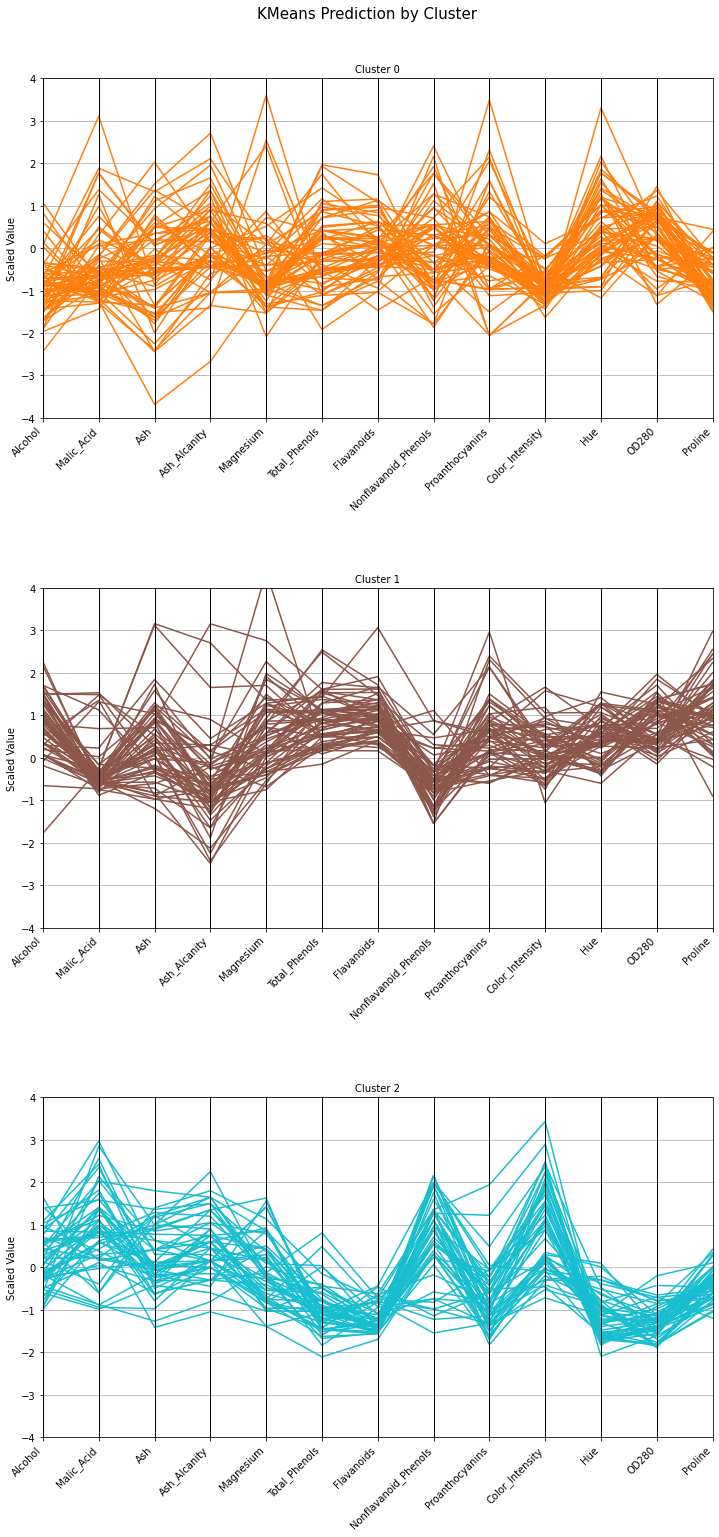

In [15]:
# Set up multiple plots for each cluster
rcParams['figure.figsize'] = 12,25
fig, axs = plt.subplots(k)
plt.subplots_adjust(hspace=0.5)
fig.suptitle('KMeans Prediction by Cluster', fontsize=15, y=0.92);

# Define color gradient
colors = plt.cm.get_cmap('tab10')(np.linspace(0.1, 0.9, k))

# Plot parallel coords for each cluster
for c, ax in zip(range(k),axs.ravel()):
    # Filter for each cluster and assign to ax
    pd.plotting.parallel_coordinates(scaled_wine[scaled_wine['Cluster']==c], 
                                     'Cluster', 
                                     color = colors[c],
                                     ax = ax)
    # Formatting
    ax.set_title(f'Cluster {c}', fontsize=10)
    ax.set_ylabel('Scaled Value', fontsize = 10)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.get_legend().remove()
    ax.set_ylim(-4, 4)
plt.show();

Intuitively, this makes sense when we think about wine. Overall, people could classify wine into two main groups: white and red, which may explain why k = 2 seemed to be a great choice during the parameter selection section. But this may be too general, as wine has so many other characteristics that extend beyond color. For example, sweet red wines are likely have more in common with fruity white wines than with dry, high tannin red wines. Then when one considers dry whites, rosés, and orange wines, it becomes harder to classify into two groups. Though wine is diverse in category, given the small sample size of this datset, three clusters seem to be an excellent fit.

<a class = 'anchor' id = 'section4'></a>

## Section 4: Dimensionality Considerations
* [Back To Top](#TOC)

This section investigates the robustness of the k-means model by observing the effects of dimensionality reduction techniques after fitting the model. 

Previously, it was determined that dimensionally reducing the dataset using PCA was ineffective in simplifying the dataset $\textbf{before}$ being fit. Here, we will observe what happens when the model is fit on the full dataset and then predicted over a dimensionally reduced dataset $\textbf{after}$ being fit. 

For a given k, we will observe how the fully fit model predicts over a compressed version of the dataset. If there are clearly defined clusters in the compressed data, then that model may be robust to dramatic changes in the data.

Three dimensionality reduction techniques are explored: principal component analysis (PCA), multi-dimensional scaling (MDS), and locally linear embedding (LLE). The first one is a linear compression technique (projections), while the latter two are nonlinear techniques. These are also generally referred to as "embeddings".

For each reduction technique, a dimensionality of 2 is chosen for the sake of data visualization. Then a k-means model is fit on the full data for k = 2, 3, 4, and 5. Cluster assignments are then made over the compressed, two-dimesional data, and these plots are shown with color-coded clusters.

For the first reduction technique, PCA, we can see that even after compressing the data down to two dimesions there are still clearly defined clusters. The model performs well for k = 2 and k = 3, but fails for k = 4 and k = 5, supporting the discussions above on the choice of k.

The benefit of using PCA is that it is linear and thus a measure of variance reduction can be given in the form of the explained variance ratio. This says that only 55% of the original information is retained in the compressed data. We can see that k-means is robust in this dataset, as it can appropriately cluster the data into 2 or 3 cluster even when the data loses 45% of its information.

Shape of original data: (178, 13)
Shape of dimensionally reduced data: (178, 2)

Explained Variance Ratio: 0.55


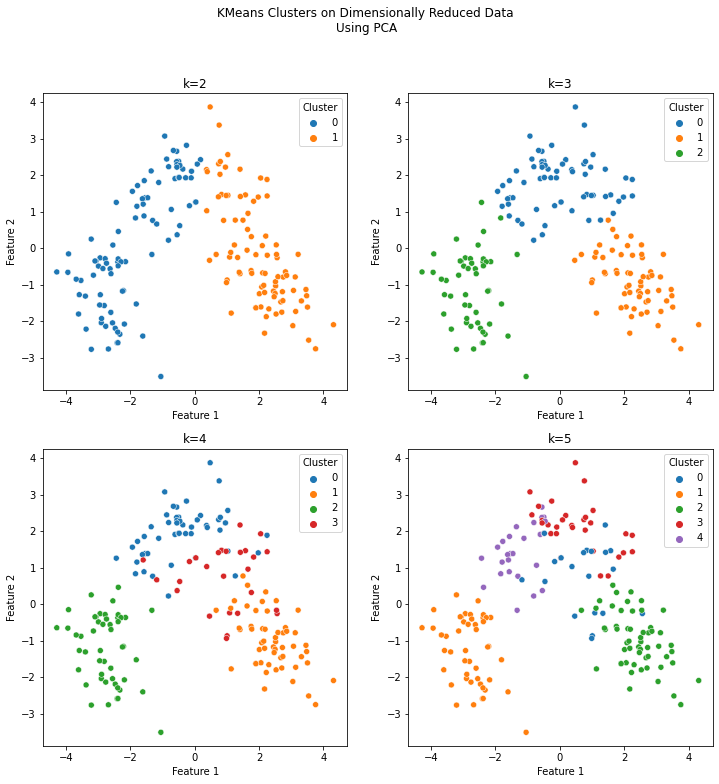

In [16]:
# Dimensionality Reduction using PCA
# Principal Component Analysis

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)
print('Shape of original data:', scaled_wine.shape)

# Reduce dimensionality of data into two dimensions (two features)
embedding = PCA(n_components=2, random_state=3)
pca = pd.DataFrame(embedding.fit_transform(scaled_wine), columns=['Feature 1', 'Feature 2'])
print('Shape of dimensionally reduced data:', pca.shape)
print('\nExplained Variance Ratio:', np.round(embedding.explained_variance_ratio_.sum(), 2))

# Create frame of plots
rcParams['figure.figsize'] = 12, 12
fig, axs = plt.subplots(2, 2)

# Loop over all k and plot
k_vals = [2, 3, 4, 5]
for k, ax in zip(k_vals, axs.ravel()):
    # Intantiate kmeans model on full data
    kmeans = KMeans(k, random_state=3)
    kmeans.fit(scaled_wine)
    pca['Cluster'] = kmeans.predict(scaled_wine) # predict over reduced data

    # Scatter plot of two features, color-coded by cluster
    sns.scatterplot(data = pca, x = 'Feature 1', y = 'Feature 2', hue = 'Cluster', palette='tab10', ax = ax);
    ax.set_title(f'k={k}');

plt.suptitle('KMeans Clusters on Dimensionally Reduced Data \nUsing PCA');

Next the nonlinear MDS embedding is applied. We see that, similar to PCA, the k-means model can appropriately cluster the data into 2 or 3 clusters after data compression. This again agrees with the discussions of model fitness above.

Shape of original data: (178, 13)
Shape of dimensionally reduced data: (178, 2)


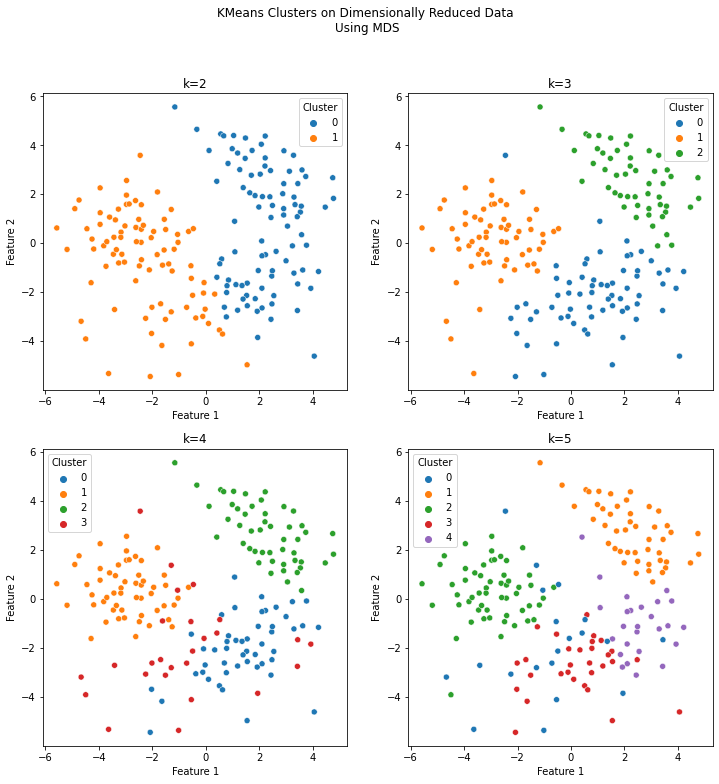

In [17]:
# Dimesionality Reduction using MDS
# Multi-Dimensional Scaling

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)
print('Shape of original data:', scaled_wine.shape)

# Reduce dimensionality of data into two dimensions (two features)
embedding = MDS(n_components=2, random_state=3)
mds = pd.DataFrame(embedding.fit_transform(scaled_wine), columns=['Feature 1', 'Feature 2'])
print('Shape of dimensionally reduced data:', mds.shape)

# Create frame of plots
rcParams['figure.figsize'] = 12, 12
fig, axs = plt.subplots(2, 2)

# Loop over all k and plot
k_vals = [2, 3, 4, 5]
for k, ax in zip(k_vals, axs.ravel()):
    # Intantiate kmeans model on full data
    kmeans = KMeans(k, random_state=3)
    kmeans.fit(scaled_wine)
    mds['Cluster'] = kmeans.predict(scaled_wine) # predict over reduced data

    # Scatter plot of two features, color-coded by cluster
    sns.scatterplot(data = mds, x = 'Feature 1', y = 'Feature 2', hue = 'Cluster', palette='tab10', ax = ax);
    ax.set_title(f'k={k}');

plt.suptitle('KMeans Clusters on Dimensionally Reduced Data \nUsing MDS');

Finally the nonlinear LLE embedding is applied. This reduction technique fails to appropriately compress the data into a feature space upon which the k-means model can appropriately cluster. This failure could be due to the nature of the data or a lack of compatablity with the k-means method. It would be interesting to see how this reduction technique performs on highly elliptical data with other clustering models.

Shape of original data: (178, 13)
Shape of dimensionally reduced data: (178, 2)


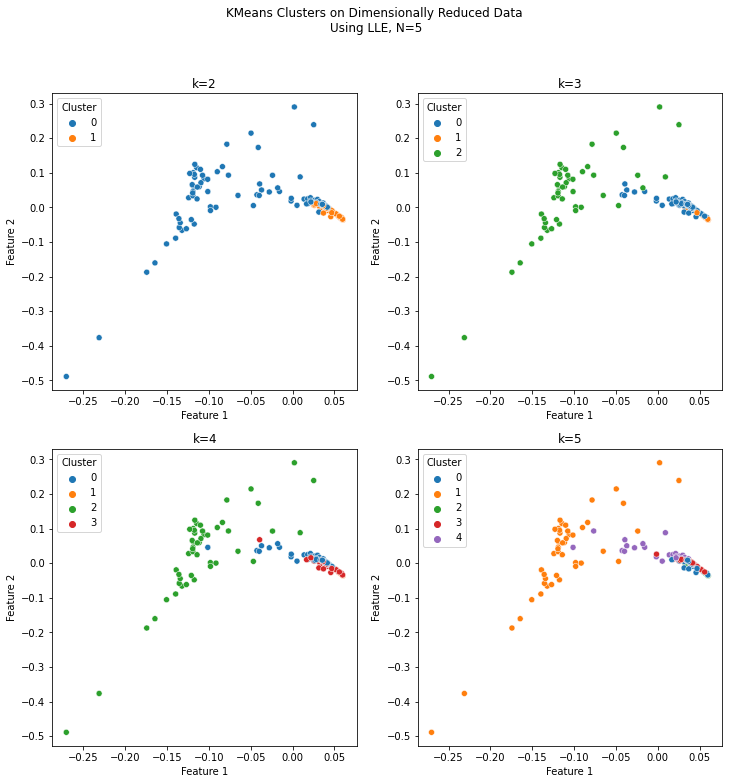

In [18]:
# Dimesionality Reduction using LLE
# Locally Linear Embedding

# Scale data
scaler = StandardScaler()
scaled_wine = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)
print('Shape of original data:', scaled_wine.shape)

# Reduce dimensionality of data into two dimensions (two features)
N = 5 # set number of neighbors for locality measure
embedding = LLE(n_components=2, n_neighbors=N, random_state=3)
lle = pd.DataFrame(embedding.fit_transform(scaled_wine), columns=['Feature 1', 'Feature 2'])
print('Shape of dimensionally reduced data:', lle.shape)

# Create frame of plots
rcParams['figure.figsize'] = 12, 12
fig, axs = plt.subplots(2, 2)

# Loop over all k and plot
k_vals = [2, 3, 4, 5]
for k, ax in zip(k_vals, axs.ravel()):
    # Intantiate kmeans model on full data
    kmeans = KMeans(k, random_state=3)
    kmeans.fit(scaled_wine)
    lle['Cluster'] = kmeans.predict(scaled_wine) # predict over reduced data

    # Scatter plot of two features, color-coded by cluster
    sns.scatterplot(data = lle, x = 'Feature 1', y = 'Feature 2', hue = 'Cluster', palette='tab10', ax = ax);
    ax.set_title(f'k={k}');

plt.suptitle(f'KMeans Clusters on Dimensionally Reduced Data \nUsing LLE, N={N}');

<a class = 'anchor' id = 'section5'></a>

## Section 5: Summary
* [Back To Top](#TOC)

In this project, an unlabeled dataset representing the chemical and spectral composition of various wines was accurately clustered into 3 groups using a k-means clutering model, with hyperparameter k empirically determined to be 3. This means that there are approximately 3 clusters of wine varietals found within the given feature set. Post-hoc analysis supported this result by visualizing model predictions over dimensionally reduced data.

Future considerations include experimenting with other clustering models and observing their performance. Do they reach the same conclusions?